In [1]:
import os
import deeptime
import pyemma
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mdtraj
from pyemma.util.contexts import settings
from deeptime.decomposition import TICA
from pandas import DataFrame
from itertools import product
mpl.use('agg')
%matplotlib inline

In [2]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.
    
    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.
    
    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores

In [3]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)

## Load data and feature selection

In [24]:
os.chdir("/home/cadeniran/u1/5ht/MSM")

files = ['data/extracted_1000_frames_stripped2.xtc', 'data/extracted_1000_frames_stripped3.xtc',
        'data/extracted_1000_frames_stripped4.xtc', 'data/extracted_1000_frames_stripped5.xtc',
        'data/extracted_1000_frames_stripped6.xtc', 'data/extracted_1000_frames_stripped7.xtc',
        'data/extracted_1000_frames_stripped8.xtc', 'data/extracted_1000_frames_stripped9.xtc',
        'data/extracted_1000_frames_stripped10.xtc']

#files = ['data/extracted_1000_frames_stripped2.xtc', 'data/extracted_1000_frames_stripped3.xtc']
pdb = 'data/stripped_trajectory2.pdb'

In [31]:
torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_feat.add_sidechain_torsions(cossin=True, periodic=False, which='all')
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)
labels = ['backbone\ntorsions']

Obtaining file info:   0%|                                | 0/9 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                    | 0/9 [00:00<?, ?it/s]

In [5]:
torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)
labels = ['backbone\ntorsions']

Obtaining file info:   0%|                                | 0/9 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                    | 0/9 [00:00<?, ?it/s]

In [6]:
sidechain_feat = pyemma.coordinates.featurizer(pdb)
sidechain_feat.add_sidechain_torsions(cossin=True, periodic=False, which='chi1')
sidechain_data = pyemma.coordinates.load(files, features=sidechain_feat)
labels = ['sidechain\ntorsions']

Obtaining file info:   0%|                                | 0/9 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                    | 0/9 [00:00<?, ?it/s]

In [7]:
chi1torsions_feat = pyemma.coordinates.featurizer(pdb)
chi1torsions_feat.add_chi1_torsions(cossin=True, periodic=False)
chi1torsions_data = pyemma.coordinates.load(files, features=chi1torsions_feat)
labels = ['chi1\ntorsions']

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "add_chi1_torsions". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Please use "add_sidechain_torsions(which=['chi1'])"
  return caller(func, *(extras + args), **kw)


Obtaining file info:   0%|                                | 0/9 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                    | 0/9 [00:00<?, ?it/s]

In [8]:
positions_feat = pyemma.coordinates.featurizer(pdb)
positions_feat.add_selection(positions_feat.select_Backbone())
positions_data = pyemma.coordinates.load(files, features=positions_feat)
labels += ['backbone atom\npositions']

Obtaining file info:   0%|                                | 0/9 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                    | 0/9 [00:00<?, ?it/s]

In [9]:
distances_feat = pyemma.coordinates.featurizer(pdb)
distances_feat.add_distances(distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False)
distances_data = pyemma.coordinates.load(files, features=distances_feat)
labels += ['backbone atom\ndistances']

Obtaining file info:   0%|                                | 0/9 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                   | 0/63 [00:00<?, ?it/s]

## Coordinate transform and discretization: TICA

In [29]:
tica = pyemma.coordinates.tica(torsions_data, lag=10, dim=4)
#tica = pyemma.coordinates.tica(positions_data, lag=10, dim=4)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|                              | 0/9 [00:00<?, ?it/s]

getting output of TICA:   0%|                             | 0/9 [00:00<?, ?it/s]

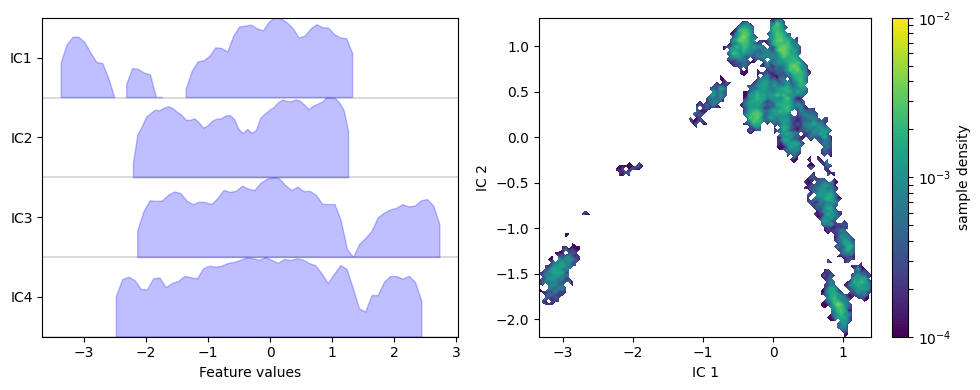

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
    feature_labels=['IC1', 'IC2', 'IC3', 'IC4'],
    ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

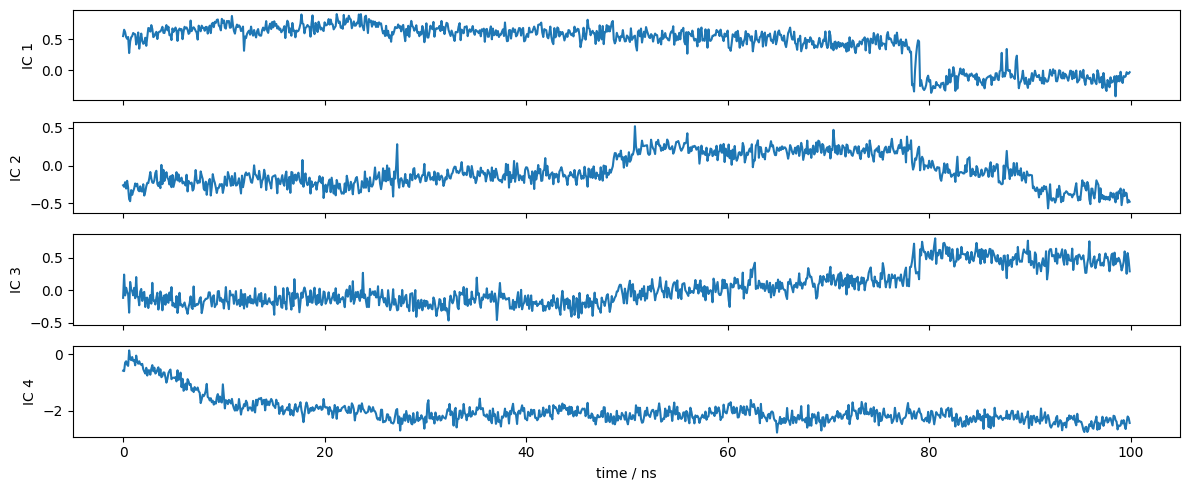

In [12]:
fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()

## Discretization

In [13]:
cluster = pyemma.coordinates.cluster_kmeans(tica_concatenated, k=250, max_iter=100, stride=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                      | 0/250 [00:00<?, ?it/s]

kmeans iterations:   0%|                                | 0/100 [00:00<?, ?it/s]

/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


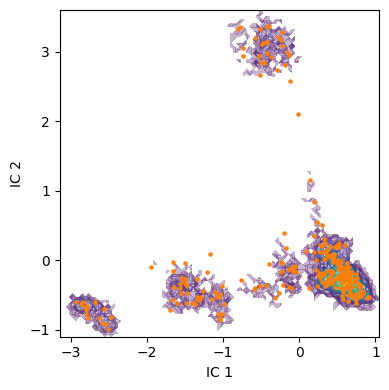

In [14]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

## MSM estimation and validation


estimating BayesianMSM:   0%|                            | 0/10 [00:00<?, ?it/s]

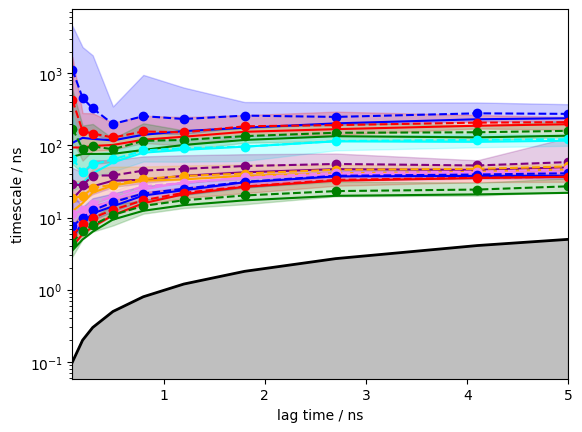

In [15]:
its = pyemma.msm.its(cluster.dtrajs, lags=50, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1);

In [16]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=10, dt_traj='100 ps')
print('fraction of states used = {:f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:f}'.format(msm.active_count_fraction))

fraction of states used = 1.000000
fraction of counts used = 1.000000


pyemma.msm.estimators.bayesian_msm.BayesianMSM[14]: Sampling MSMs:   0%| | 0/100

estimating BayesianMSM:   0%|                             | 0/9 [00:00<?, ?it/s]

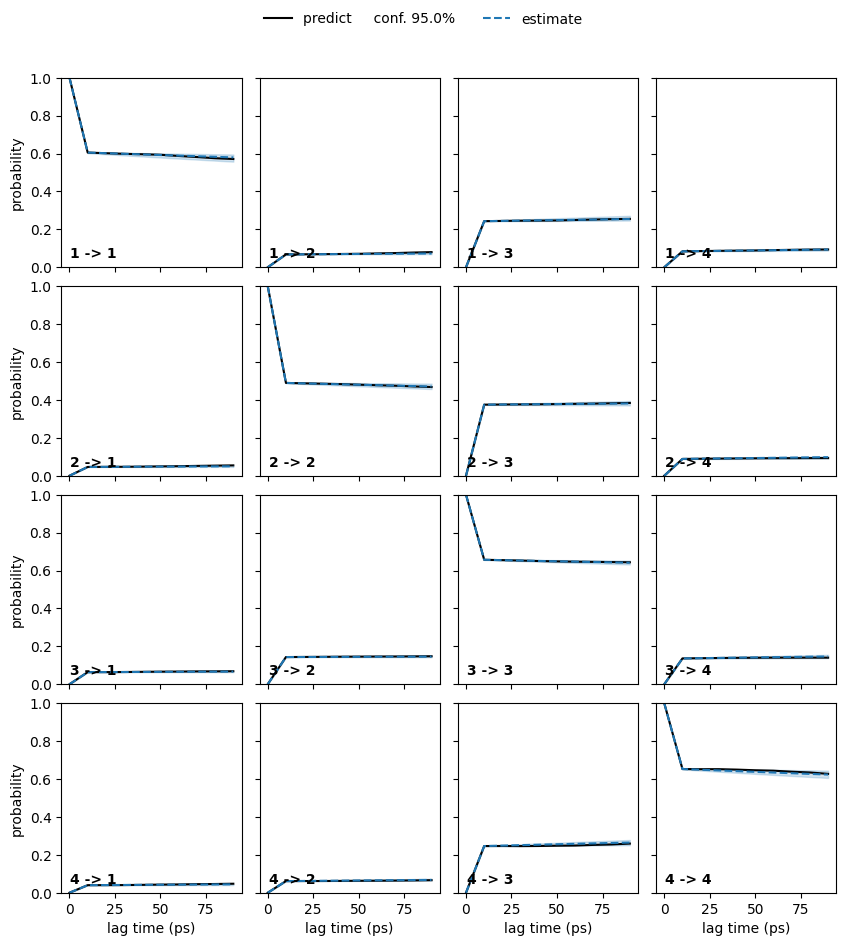

In [17]:
nstates = 4
bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=10, dt_traj='100 ps')
p0 = pyemma.plots.plot_cktest(bayesian_msm.cktest(nstates), units='ps');
p0[0].savefig('cktest.png', dpi=600)

## MSM spectral analysis

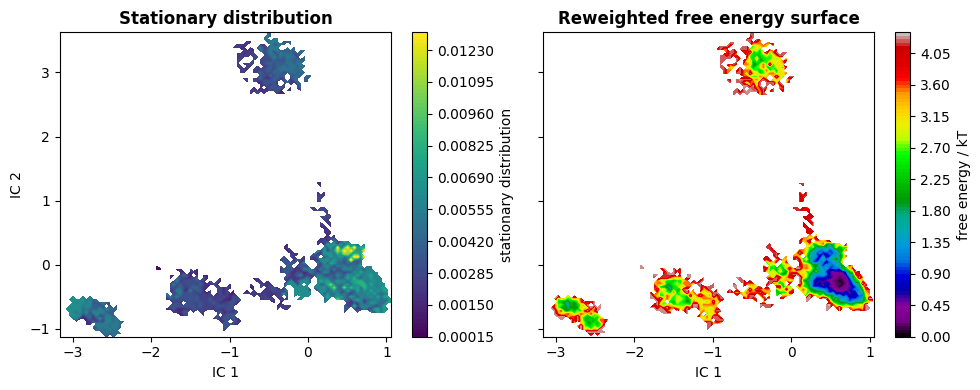

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()
#fig.savefig('contour.png', dpi=600)

The first eigenvector is one: True (min=0.9999999999996197, max=1.000000000000293)


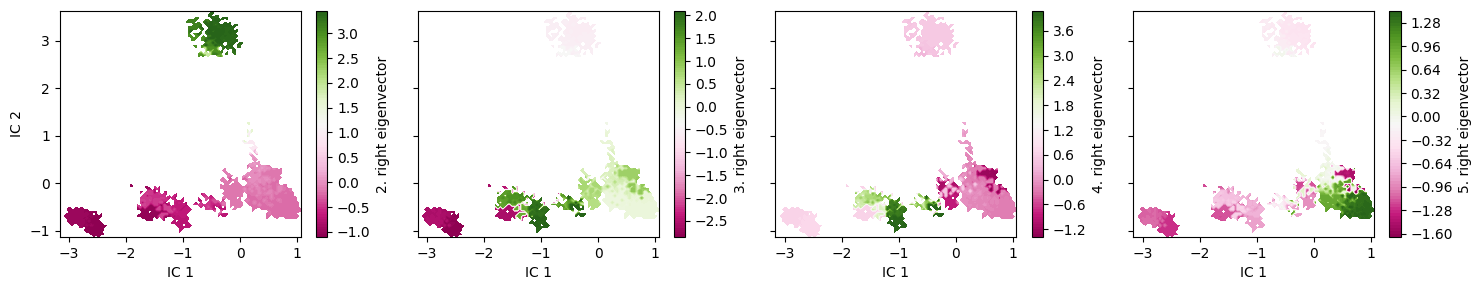

In [19]:
eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        eigvec[dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

## PCCA & TPT

In [20]:
msm.pcca(nstates)

PCCA-123884836189712:[{'P': array([[0.1       , 0.        , 0.        , ..., 0.        , 0.        ,
                             0.        ],
                            [0.        , 0.33333333, 0.        , ..., 0.        , 0.        ,
                             0.        ],
                            [0.        , 0.        , 0.27777778, ..., 0.        , 0.        ,
                             0.        ],
                            ...,
                            [0.        , 0.        , 0.        , ..., 0.34375   , 0.        ,
                             0.        ],
                            [0.        , 0.        , 0.        , ..., 0.        , 0.52380952,
                             0.        ],
                            [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
                             0.20338983]]),
                      'm': None}]

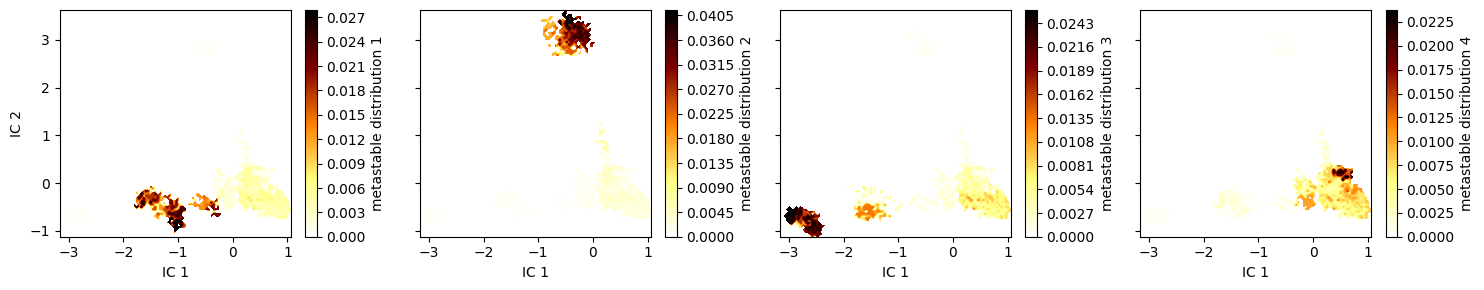

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

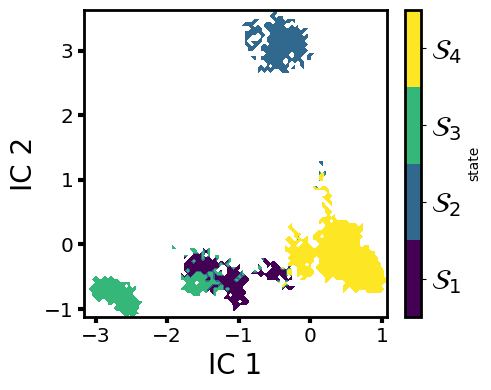

In [57]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)

plt.rcParams['axes.linewidth'] = 2.0
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

ax.set_xlabel('IC 1', fontsize=20)
ax.set_ylabel('IC 2', fontsize=20)
plt.tick_params(axis='both',labelsize='14.5', length=4, width=3)
misc['cbar'].ax.tick_params(labelsize=20)
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1) for i in range(nstates)])
fig.tight_layout()
plt.savefig("/home/cadeniran/ipn/figs/icstates.png")

In [ ]:
pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 10)
torsions_source = pyemma.coordinates.source(files, features=torsions_feat)
pyemma.coordinates.save_trajs(
    torsions_source,
    pcca_samples,
    outfiles=['/data/pcca{}_10samples.pdb'.format(n + 1)
        for n in range(msm.n_metastable)])

In [34]:
print('state\tπ\t\tG/kT')
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))

state	π		G/kT
1	0.076629	2.568778
2	0.082322	2.497116
3	0.092187	2.383932
4	0.748861	0.289201


In [36]:
from itertools import product

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / ns:


,1,2,3,4
1,0.00,1212677.70,1310227.27,97275.84
2,1191499.05,0.00,1335432.13,139562.60
3,1194343.48,1239048.59,0.00,121713.22
4,1073839.65,1144900.33,1215813.90,0.00


## Transition path theory

In [39]:
start, final = 1, 3
A = msm.metastable_sets[start]
B = msm.metastable_sets[final]
flux = pyemma.msm.tpt(msm, A, B)

cg, cgflux = flux.coarse_grain(msm.metastable_sets)

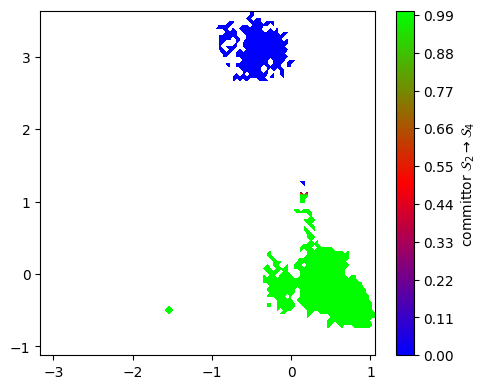

In [40]:
fig, ax = plt.subplots(figsize=(5, 4))

pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    flux.committor[dtrajs_concatenated],
    cmap='brg',
    ax=ax,
    mask=True,
    cbar_label=r'committor $\mathcal{S}_%d \to \mathcal{S}_%d$' % (
        start + 1, final + 1))
fig.tight_layout()